# Otimização de função Shaffer's f6

In [8]:
# Importa bibliotecas necessárias
import numpy as np  # Operações numéricas vetorizadas
import matplotlib.pyplot as plt  # Plotagem de gráficos
import imageio.v2 as imageio  # Criação de vídeo a partir de imagens
import os  # Manipulação de arquivos (ex: deletar imagens temporárias)
import csv  # Para salvar dados em formato CSV

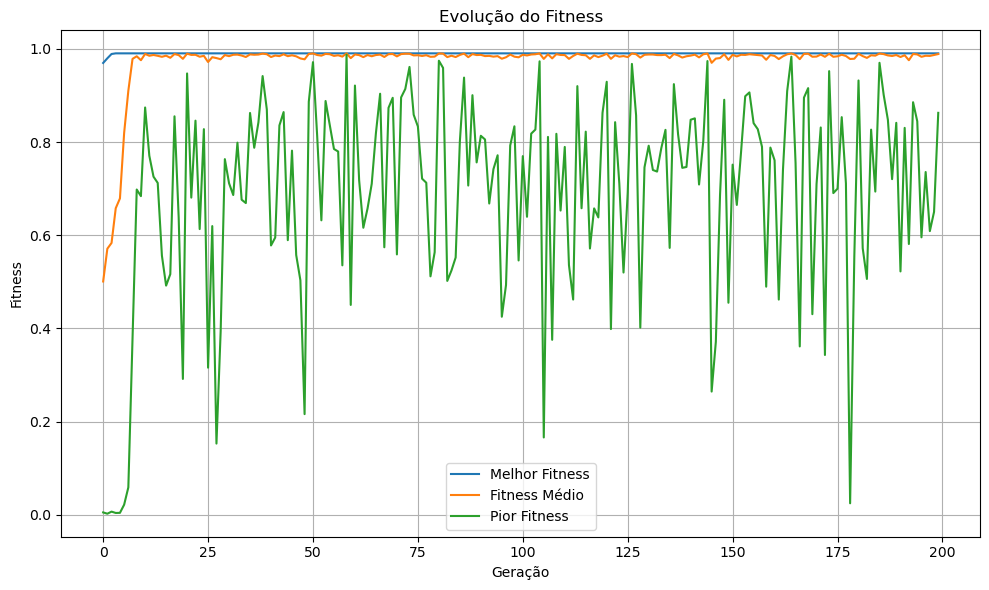

ValueError: Could not find a backend to open `evolucao_populacao.mp4`` with iomode `w?`.
Based on the extension, the following plugins might add capable backends:
  FFMPEG:  pip install imageio[ffmpeg]
  pyav:  pip install imageio[pyav]

In [9]:


# Função objetivo Schaffer F6: função de benchmark difícil para otimização
def schaffer_f6(x, y):
    num = np.sin(np.sqrt(x**2 + y**2))**2 - 0.5
    denom = (1 + 0.001 * (x**2 + y**2))**2
    return 0.5 - num / denom  # Resultados entre 0 e 1; máximo global em (0, 0)

# Inicializa a população com coordenadas aleatórias dentro dos limites
def initialize_population(size, bounds):
    return np.random.uniform(bounds[0], bounds[1], (size, 2))

# Avalia o fitness da população usando a função Schaffer F6
def evaluate_fitness(population):
    return schaffer_f6(population[:, 0], population[:, 1])

# Seleção por torneio: escolhe k indivíduos aleatoriamente e seleciona o melhor
def tournament_selection(population, fitness, k=3):
    selected = []
    for _ in range(len(population)):
        indices = np.random.choice(len(population), k)  # k indivíduos aleatórios
        winner = indices[np.argmax(fitness[indices])]  # Seleciona o melhor
        selected.append(population[winner])
    return np.array(selected)

# Crossover (recombinação): mistura dois pais para gerar filhos
def crossover(parents, crossover_rate=0.9):
    offspring = []
    for i in range(0, len(parents), 2):
        p1, p2 = parents[i], parents[(i+1) % len(parents)]
        if np.random.rand() < crossover_rate:
            alpha = np.random.rand()  # Grau de mistura entre os pais
            child1 = alpha * p1 + (1 - alpha) * p2
            child2 = alpha * p2 + (1 - alpha) * p1
            offspring.extend([child1, child2])
        else:
            offspring.extend([p1, p2]) # Sem crossover, filhos são cópias
    return np.array(offspring)

# Mutação: altera aleatoriamente uma coordenada de alguns indivíduos
def mutate(population, mutation_rate=0.05, bounds=(-10, 10)):
    for i in range(len(population)):
        if np.random.rand() < mutation_rate:
            gene = np.random.randint(2)   # Escolhe entre x (0) ou y (1)
            mutation = np.random.normal(0, 0.5)  # Gera valor aleatório normal
            population[i, gene] += mutation
            # Garante que o novo valor esteja dentro dos limites
            population[i, gene] = np.clip(population[i, gene], bounds[0], bounds[1])
    return population

    # Plota a população sobre o gráfico da função
def plot_population(pop, generation, bounds=(-10, 10), resolution=100):
    x = np.linspace(bounds[0], bounds[1], resolution)
    y = np.linspace(bounds[0], bounds[1], resolution)
    X, Y = np.meshgrid(x, y)
    Z = schaffer_f6(X, Y)

    plt.figure(figsize=(6,6))
    plt.contourf(X, Y, Z, levels=50, cmap='viridis')
    plt.colorbar(label='Fitness')
    plt.scatter(pop[:, 0], pop[:, 1], c='red', s=20, edgecolors='black')
    plt.title(f'Geração {generation}')
    plt.xlim(bounds)
    plt.ylim(bounds)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.tight_layout()
    filename = f'gen_{generation:03d}.png'
    plt.savefig(filename)
    plt.close()
    return filename

def genetic_algorithm():
    bounds = (-10, 10)
    pop_size = 100
    generations = 200
    crossover_rate = 0.9
    mutation_rate = 0.05
    elite_count = 2  # Número de melhores indivíduos preservados (elitismo)

    population = initialize_population(pop_size, bounds)
    best_fitness = []
    mean_fitness = []
    worst_fitness = []
    best_individuals = []  # Armazena o melhor indivíduo por geração
    image_files = []  

    for gen in range(generations):
        fitness = evaluate_fitness(population)
        idx_sorted = np.argsort(-fitness)  # Ordena decrescentemente
        elites = population[idx_sorted[:elite_count]]  # Guarda os melhores

        # Armazena o melhor da geração
        best_idx = idx_sorted[0]
        best_individual = population[best_idx]
        best_fitness_value = fitness[best_idx]
        best_individuals.append([gen, best_individual[0], best_individual[1], best_fitness_value])

        best_fitness.append(np.max(fitness))
        mean_fitness.append(np.mean(fitness))
        worst_fitness.append(np.min(fitness))
        image_files.append(plot_population(population, gen, bounds))  # Salva imagem

        selected = tournament_selection(population, fitness)  # Seleção
        offspring = crossover(selected, crossover_rate)  # Crossover
        offspring = mutate(offspring, mutation_rate, bounds)  # Mutação

        # Reinsere elites e substitui os demais
        population = np.vstack((elites, offspring[:-elite_count]))

    # Gráfico da evolução do fitness
    plt.figure(figsize=(10,6))
    plt.plot(best_fitness, label='Melhor Fitness')
    plt.plot(mean_fitness, label='Fitness Médio')
    plt.plot(worst_fitness, label='Pior Fitness')
    plt.xlabel('Geração')
    plt.ylabel('Fitness')
    plt.title('Evolução do Fitness')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

    # Criar vídeo
    with imageio.get_writer('evolucao_populacao.mp4', fps=10, macro_block_size=1) as writer:
        for filename in image_files:
            image = imageio.imread(filename)
            writer.append_data(image)

    for filename in image_files:
        os.remove(filename)

    # Salvar melhores indivíduos em CSV
    with open('melhores_por_geracao.csv', 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['Geração', 'Melhor_X', 'Melhor_Y', 'Fitness'])
        writer.writerows(best_individuals)

    print("Vídeo salvo como 'evolucao_populacao.mp4'.")
    print("Melhores indivíduos salvos em 'melhores_por_geracao.csv'.")

# Executar
genetic_algorithm()


